## **Import the neccessary libraries**

In [ ]:
!pip install svgling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import nltk
import svgling
import pandas as pd
from nltk.metrics import jaccard_distance
import nltk
from nltk import CFG, ChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser

## **Expand the grammar**

Lazy cats play with mice.

In [ ]:
grammar = CFG.fromstring('''
  S  -> NP VP | NP
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" |"dogs" | "mice" | NNS CC NNS
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or"
  VP  -> VT PP
  VT  -> "play"
  PP  -> IN NP
  IN  -> "with"
  ''')

This grammar is desiged to work with both sentences, the one from the slides : "small cats and mice" and also the one from the exercise : "Lazy cats play with mice"

## **Define Parsers**

We define four different parsers in NLTK, each implementing a unique parsing strategy:

* ChartParser - For each rule defined by a specific strategy, apply that rule to all relevant edges in the chart. Continue this process repeatedly until no additional edges are generated. The chosen strategy dictates how new edges are incorporated into the chart. Specifically, in the case of the generic parser, the strategy examines:

    1.  Identifying new edges that can be added without
considering any existing edges.
    2.  Determining new edges based on one particular existing edge.
    3. Creating new edges by combining a specific pair of existing edges.

* BottomUpChartParser -Implements a bottom-up parsing strategy, starting from the words (leaves) of the sentence and building up to the root (start symbol).
    1. Start with an empty chart that will store partial parses.
    2. Begin by adding edges for all terminal symbols (words) in the input, based on the grammar.
    3. For each rule in the grammar, check if the current edges in the chart can form the right-hand side of a production rule. If they match, create a new edge for the left-hand side of the rule and add it to the chart.
    4. Continue applying grammar rules to the edges in the chart iteratively until no new edges can be generated.
    5. Verify if the start symbol (goal symbol) spans the entire input sentence. If it does, the parsing is successful.

* BottomUpLeftCornerChartParser - A refinement of the bottom-up strategy that combines elements of top-down prediction with bottom-up parsing. The parser first identifies a "left corner" (the first symbol in a production rule) to guide parsing, reducing some redundant derivations.

* LeftCornerChartParser - Implements left-corner parsing, which is a hybrid between top-down and bottom-up parsing. Begins parsing by identifying the left corner of a production rule and incrementally building the parse tree.


We have defined two variables for each parser:

* One with trace=0, suppressing tracing output, used when parsing a sentence for visualization (drawing the parse tree).
* One with trace=1, enabling tracing output, used to analyze the parsing process step by step.

In [ ]:
chart_parser_with_trace = ChartParser(grammar, trace=1)
bottom_up_chart_parser_with_trace = BottomUpChartParser(grammar, trace=1)
bottom_up_left_corner_chart_parser_with_trace = BottomUpLeftCornerChartParser(grammar, trace=1)
left_corner_chart_parser_with_trace = LeftCornerChartParser(grammar, trace=1)

chart_parser_no_trace = ChartParser(grammar, trace=0)
bottom_up_chart_parser_no_trace = BottomUpChartParser(grammar, trace=0)
bottom_up_left_corner_chart_parser_no_trace = BottomUpLeftCornerChartParser(grammar, trace=0)
left_corner_chart_parser_no_trace = LeftCornerChartParser(grammar, trace=0)


In [ ]:
#Function to get the list of explored edges and the number of edges for each parsing strategy
def create_results(model_no_trace,model_with_trace,sentence):
  print("List of explored edges:\n")
  parsed_sentence = model_no_trace.parse(sentence)
  parser = model_with_trace.chart_parse(sentence)
  print("Number of edges =",parser.num_edges())
  return parsed_sentence


## **Grammer check**

### **Checking the lab's slide example**

In [ ]:
sentence2 = ['small','cats','and','mice'] # to check for the example from the lab slides

In [ ]:
parsed_sentence = create_results(chart_parser_no_trace,chart_parser_with_trace, sentence2)


List of explored edges:

|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] S  -> NP * VP
|[-------------------]         .         .| [0:2] S  -> NP *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] S  -> NP * VP
|.         [---------]         .         .| [1:2] S  

Resulting Tree


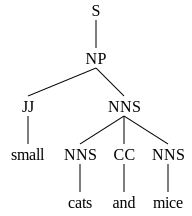

In [ ]:
print("Resulting Tree")
svgling.draw_tree(list(parsed_sentence)[0])

As we can see the grammer works good with the example from slides. Since here we need to have a Start symbol the only thing that has changed is the addition of that. The number of edges explored here is higher than the ones in the slides because we have the root (start symbol) added.

### **Checking exercise example**

In [ ]:
sentence = ["lazy", "cats", "play", "with", "mice"]

In [ ]:
parsed_sentence = create_results(chart_parser_no_trace,chart_parser_with_trace, sentence)


List of explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       [------->       .       .       .| [1:2] NNS -> NNS * CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|[--------------->       .       .       .| [0:2] NP -> NP * CC NP
|.       [------->       .       .       .| [1:2] S  -> NP * 

Resulting Tree


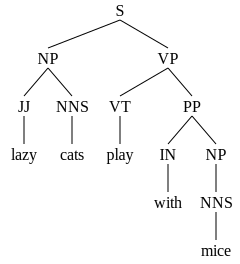

In [ ]:
print("Resulting Tree")
svgling.draw_tree(list(parsed_sentence)[0])

From the ChartParser we can see that the generated tree is correct. We are going to try some other parsing strategies and see how the efficency and performance will be.

## **Performing the constituency parsing using other parsers**

### **BottomUpChartParser**

In [ ]:
parsed_sentence = create_results(bottom_up_chart_parser_no_trace,bottom_up_chart_parser_with_trace,sentence)

List of explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|>       .       .       .       .       .| [0:0] JJ -> * 'lazy'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|>       .       .       .       .       .| [0:0] NP -> * JJ NNS
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       >       .       .       .       .| [1:1] NNS -> * 'cats'
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       >       .       .       .       .| [1:1] NP -> * NNS
|.       >       .       .       .       .| [1:1] NNS -> * NNS CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|.       [-------]       .       .       .| [1:2] NP -> N

Resulting Tree:



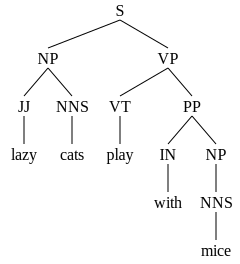

In [ ]:
print("Resulting Tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

### **BottomUpLeftCornerChartParser**

In [ ]:
parsed_sentence = create_results(bottom_up_left_corner_chart_parser_no_trace,bottom_up_left_corner_chart_parser_with_trace,sentence)

List of explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|.       [------->       .       .       .| [1:2] NNS -> NNS * CC NNS
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|[--------------->       .       .       .| [0:2] NP -> NP * CC NP
|.       [------->       .       .       .| [1:2] S  -> NP * 

Resulting Tree:



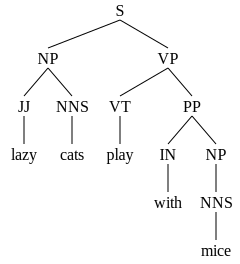

In [ ]:
print("Resulting Tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

### **LeftCornerChartParser**

In [ ]:
parsed_sentence = create_results(left_corner_chart_parser_no_trace,left_corner_chart_parser_with_trace,sentence)

List of explored edges:

|.  lazy .  cats .  play .  with .  mice .|
|[-------]       .       .       .       .| [0:1] 'lazy'
|.       [-------]       .       .       .| [1:2] 'cats'
|.       .       [-------]       .       .| [2:3] 'play'
|.       .       .       [-------]       .| [3:4] 'with'
|.       .       .       .       [-------]| [4:5] 'mice'
|[-------]       .       .       .       .| [0:1] JJ -> 'lazy' *
|[------->       .       .       .       .| [0:1] NP -> JJ * NNS
|.       [-------]       .       .       .| [1:2] NNS -> 'cats' *
|.       [-------]       .       .       .| [1:2] NP -> NNS *
|[---------------]       .       .       .| [0:2] NP -> JJ NNS *
|[--------------->       .       .       .| [0:2] S  -> NP * VP
|[---------------]       .       .       .| [0:2] S  -> NP *
|.       [------->       .       .       .| [1:2] S  -> NP * VP
|.       [-------]       .       .       .| [1:2] S  -> NP *
|.       .       [-------]       .       .| [2:3] VT -> 'play' *
|.      

Resulting Tree:



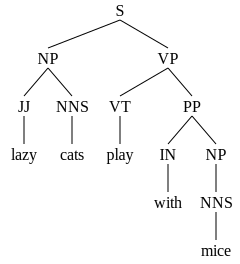

In [ ]:
print("Resulting Tree:\n")
svgling.draw_tree(list(parsed_sentence)[0])

## **Analysis and Conclusions**





*   Chart Parser - 31 nodes generated
*   Bottom Up Chart Parser - 52 nodes generated
*   Bottom Up Left Corner Chart Parser - 31 nodes generated
*   Left Corner Chart Parser - 25 nodes generated


From the experiments done all the resulting trees are accurate based on our sentence, but we can observe that the number of nodes generated changes for each of them because of the way that they explore the edges while parsing.

The most efficent parser for this sentence is the ***Left Corner Chart Parser***, as it generates the fewest nodes, 25. Since it uses both bottom-up and top-down recognition, while also using the left corner of production rules, results in minimizing the unnecessary explorations of edges. This makes it particularly well-suited for grammars with recursive or ambiguous rules.

***Bottom Up Chart Parser*** is the least efficient parser in this comparison, generating the highest number of nodes. This happens because this approach can waste resources exploring irrelevant derivations, especially for grammars with many rules.


While the ***Chart Parser*** and ***BottomUpLeftCornerChartParser*** generates the same number of nodes, performing reasonably well.

***Chart Parser*** tends to filter redundent edges that will not be usefull for the given edge, as the parser tries to only explore potential and successful edges that can  contribute to the final tree.

***BottomUpChartParser*** mostly does not filter any edges, as it looks for all posible edges starting from the bottom, that is why it explored the maximum number of edges compared to the other strategies.

***BottomUpLeftCornerChartParser*** also parses starting from bottom, but it also takes into account the left-corner contraints, eliminating unneceseray explorations, hence it filters out the edges not consistent with the left-corner contraints.

***Left Corner Chart Parser*** uses both bottom-up and top-down recognition, while also using the left corner of production rules, and it filters the edge if it does not subsume new words.


## Final Conclusion
It is important to state that none of the parsers are inherently incorrect or inefficient, rather, each operates differently and should be chosen based on the specific requirements of the task to achieve optimal results. Additionally, our comparison was limited to a single sentence, and a comprehensive analysis involving a wider range of sentences would be necessary to draw more definitive conclusions. Despite this limitation, the Left Corner Chart Parser appears to be the preferable choice due to its demonstrated efficiency. However, selecting the most suitable parser ultimately depends on the broader context and specific parsing needs.



